
### **Bias-correcting and spatial downscaling**  

##### This jupyter notebook runs through the steps for bias correcting and downscaling output from the EC-Earth3-Veg Global Climate Model under CMIP6.

Author: Adam Young  
Date: 2023-02-10  
Contact: adam.m.young@outlook.com  

--------------------------------------

The steps for this example are as follows:  
1. Load in required libraries
2. Read in 30 yr of data for daily near-surface maximum air temperature (tasmax \[&deg;C\]):
    - Reference Data Set (ERA5, 1980-2009)  
    - Historical GCM output (EC-Earth3-Veg, 1980-2009)  
    - Future projected GCM output (EC-Earth3-Veg, 2030-2059)  

    The above datasets are all read in NetCDF format using the [xarray][1] library  
3. For select grid cells/locations, apply a quantile delta mapping approach ([Cannon et al. 2015][2]) to bias correct near-surface maximum air temperature. Use basic stats and numpy packages at first to walk through the individual steps. 
4. Compare results from step 3 to bias corrections derived using the [xclim][3] library.  

[1]: <https://docs.xarray.dev>
[2]: <https://doi.org/10.1175/JCLI-D-14-00754.1>
[3]: <https://github.com/Ouranosinc/xclim>


First, import required packages ...

In [1]:
from pathlib import Path

import numpy as np

# Module for bias correcting from xclim
from xclim.sdba import QuantileDeltaMapping

import xarray as xr

Next, read in the following three datasets ...  

 - ref: reference observational/reanalysis dataset, here [ERA5][4]. Use years of 1980-2009 for reference time period
 - hst: historical GCM data for [EC-Earth3-Veg][5] for the same time period as ERA5 (1980-2009)
 - prj: projected GCM output for EC-Earth3-Veg for 2030-2059 and 2060-2089

As a brief aside, EC-Earth3-Veg was determined to have the highest ranking among 101 GCM-ensemble combinations for Alaska using the [gcmeval tool][6].

[4]: <https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5>
[5]: <https://doi.org/10.5194/gmd-15-2973-2022>
[6]: <https://gcmeval.met.no>

In [2]:
# Get current working directory based on location of current ipynb file in the
# notebooks folder and then link to path for already pre-processed ERA5 and GCM
# datasets.
currpath = Path.cwd()
datapath = currpath.joinpath('../data')
era5_datapath = datapath.joinpath('processed/climate/era5')
gcm_datapath = datapath.joinpath('processed/climate/cmip6/EC-Earth3-Veg')

# Set yr ranges
hst_yr = np.arange(1980,2010) # Historical years for reference
prj_yr = np.arange(2030,2060) # Projected years

# The following lines of code are commented out, but they would provide the 
# method for loading the spatial datasets and extracting all data needed to 
# conduct the analysis for a single location/grid cell.

ref_filelist = list(era5_datapath.glob('tasmax*'))
gcm_filelist = list(gcm_datapath.glob('tasmax*'))

# Sort filelist names
ref_filelist.sort()
gcm_filelist.sort()

# Print first 10 filenames for ERA5 as a check ...
print([x.name for x in ref_filelist[:10]])


['tasmax_era5_1979.nc', 'tasmax_era5_1980.nc', 'tasmax_era5_1981.nc', 'tasmax_era5_1982.nc', 'tasmax_era5_1983.nc', 'tasmax_era5_1984.nc', 'tasmax_era5_1985.nc', 'tasmax_era5_1986.nc', 'tasmax_era5_1987.nc', 'tasmax_era5_1988.nc']


In [3]:
# Also print last 10 filenames for GCM files ...
print([x.name for x in gcm_filelist[-10:]])

['tasmax_EC-Earth3-Veg_2090.nc', 'tasmax_EC-Earth3-Veg_2091.nc', 'tasmax_EC-Earth3-Veg_2092.nc', 'tasmax_EC-Earth3-Veg_2093.nc', 'tasmax_EC-Earth3-Veg_2094.nc', 'tasmax_EC-Earth3-Veg_2095.nc', 'tasmax_EC-Earth3-Veg_2096.nc', 'tasmax_EC-Earth3-Veg_2097.nc', 'tasmax_EC-Earth3-Veg_2098.nc', 'tasmax_EC-Earth3-Veg_2099.nc']


In [4]:
# Use parallel=True below to initiate use of dask arrays and parallel 
# computing. This is likely necessary on personal computers due to memory 
# needs. Separate out gcm into both historical and projected variables based on
# years/time periods. Then delete gcm variable ('del gcm') as no longer needed.

ref = xr.open_mfdataset(ref_filelist,engine='h5netcdf',parallel=True)
gcm = xr.open_mfdataset(gcm_filelist,engine='h5netcdf',parallel=True)

ref = ref.sel(time=slice(str(hst_yr[0]),str(hst_yr[-1])))
hst = gcm.sel(time=slice(str(hst_yr[0]),str(hst_yr[-1])))
prj = gcm.sel(time=slice(str(prj_yr[0]),str(prj_yr[-1])))

del gcm


We can look at an example of the parallized dask array and see the "chunks" used for this parallelization. Here we can look at a preview of the results for temperature. The default chunking is done by year (time dimension = 365 days).

In [5]:
ref['tasmax']

<xarray.DataArray 'tasmax' (time: 10950, lat: 178, lon: 569)>
dask.array<getitem, shape=(10950, 178, 569), dtype=float32, chunksize=(365, 178, 569), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -177.0 -176.8 -176.5 -176.2 ... -35.5 -35.25 -35.0
  * lat      (lat) float32 35.0 35.25 35.5 35.75 36.0 ... 78.5 78.75 79.0 79.25
  * time     (time) object 1980-01-01 00:00:00 ... 2009-12-31 00:00:00
Attributes:
    units:      °C
    long_name:  Maximum 2 metre temperature

Next, we will spatially downscale by linear interpolation the GCM data to the resolution of ERA5. They need to be on the same grid system and align with each other to do the bias corrections.

In [6]:
ref_lat = ref['lat'].values
ref_lon = ref['lon'].values

hst = hst.interp(lat=ref_lat,lon=ref_lon,method="linear")
prj = prj.interp(lat=ref_lat,lon=ref_lon,method="linear")

Next, filter the datasets to only a single grid cell based on latitude and longitude. Here we will use Fairbanks, Alaska.

In [7]:
coords = dict(lon=-147.72,lat=64.8401) # Coordinates for Fairbanks AK
ref_pt = ref.sel(lat=coords['lat'],lon=coords['lon'],method="nearest")
hst_pt = hst.sel(lat=coords['lat'],lon=coords['lon'],method="nearest")
prj_pt = prj.sel(lat=coords['lat'],lon=coords['lon'],method="nearest")

To complete and run the parallelization to get output read into memory, we need to calculate the values using the 'compute()' dask function

In [8]:
ref_pt = ref_pt.compute()
hst_pt = hst_pt.compute()
prj_pt = prj_pt.compute()

For the final step of reading in the data before we get to the bias corrections, let's check the output of the values we just calculated.

First, let's plot the average monthly un-corrected values for each variable ...

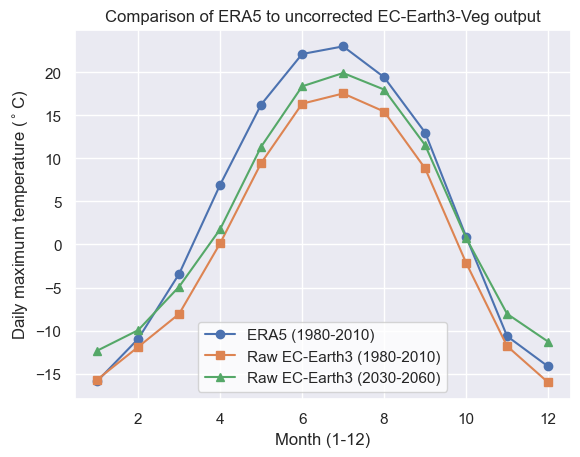

In [9]:
ref_mon_avg = ref_pt.groupby('time.month').mean()
hst_mon_avg = hst_pt.groupby('time.month').mean()
prj_mon_avg = prj_pt.groupby('time.month').mean()

x = np.arange(1,12+1) # 1d array of 1-12 for month in plotting below
y1 = ref_mon_avg['tasmax'].values
y2 = hst_mon_avg['tasmax'].values
y3 = prj_mon_avg['tasmax'].values

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

plt.plot(x,y1,'-o',label='ERA5 (1980-2010)')
plt.plot(x,y2,'-s',label='Raw EC-Earth3 (1980-2010)')
plt.plot(x,y3,'-^',label='Raw EC-Earth3 (2030-2060)')
plt.title('Comparison of ERA5 to uncorrected EC-Earth3-Veg output')
plt.xlabel('Month (1-12)')
plt.ylabel('Daily maximum temperature ($^\circ$C)')
plt.legend(facecolor='w')
plt.show()

From the above plot you can see that ERA5 historical maximum daily temperatures are higher than what is being projected during the future for the EC-Earth-Veg output. Now we can do an initial bias correction to see how this adjusts what we see in the figure above.

To begin, we need to define a few simple functions that will allow us to perform the quantile delta mapping bias corrections.

In [10]:
from scipy.interpolate import interp1d as interp

def ecdf(x,axis=0,sort=False):

    if sort:
        x = np.sort(x,axis=axis)

    n = x.shape[axis]
    y = np.arange(1,n+1) / n
    
    return x, y

def invcdf(x0,q0,q1,method='linear'):

    fx = interp(x=q0,y=x0,
                kind=method,
                bounds_error=True,
                assume_sorted=True)

    x1 = fx(q1)

    return x1

ref_cdf, quantiles = ecdf(
    ref_pt['tasmax'].sel(time=ref_pt.time.dt.month==7).values,sort=True)

Now plot the empirical distrbution function at a daily scale for daily max temperature of ERA5

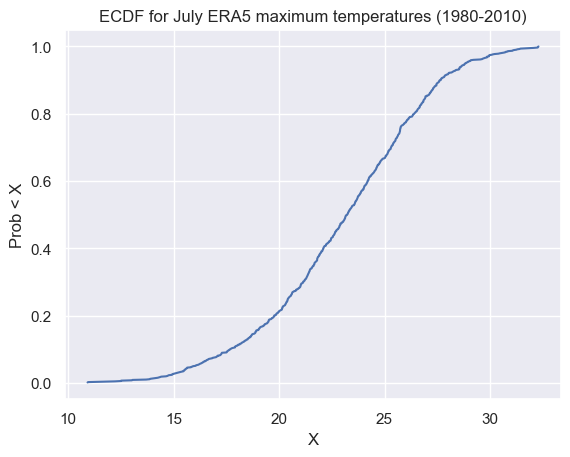

In [11]:
plt.plot(ref_cdf,quantiles)
plt.title('ECDF for July ERA5 maximum temperatures (1980-2010)')
plt.xlabel('X')
plt.ylabel('Prob < X')
plt.show()


Calculate the empirical distribution function and quantiles for the reference dataset (ref), historical gcm data (hst), and projected future data (prj).

Additionally, plot Q-Q plots comparing ERA5 to un-corrected GCM data. The below plot further deomstrates that the EC-Earth3-Veg GCM underestimates daily maximum ERA5 July air temperatue. 

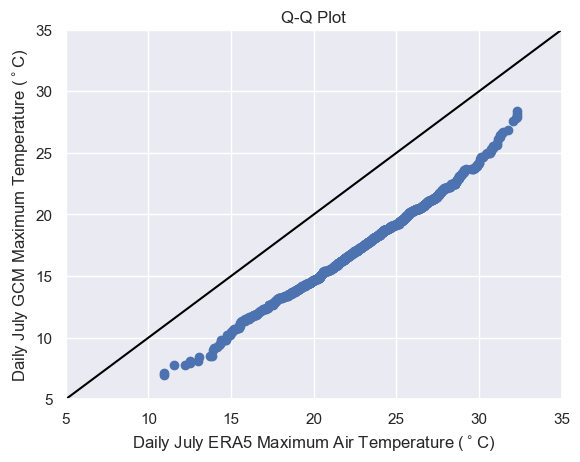

In [12]:
ref_cdf, hst_quantiles = ecdf(
    ref_pt['tasmax'].sel(time=ref_pt.time.dt.month==7).values,sort=True)
hst_cdf, _ = ecdf(
    hst_pt['tasmax'].sel(time=hst_pt.time.dt.month==7).values,sort=True)
prj_cdf, prj_quantiles = ecdf(
    prj_pt['tasmax'].sel(time=prj_pt.time.dt.month==7).values,sort=True)

plt.scatter(ref_cdf,hst_cdf)
plt.plot([5,35],[5,35],color='black') # 1:1 line
plt.xlim(5,35)
plt.ylim(5,35)
plt.title('Q-Q Plot')
plt.xlabel('Daily July ERA5 Maximum Air Temperature ($^\circ$C)')
plt.ylabel('Daily July GCM Maximum Temperature ($^\circ$C)')
plt.show()

Now perform the quantile delta mapping method for July temperatures

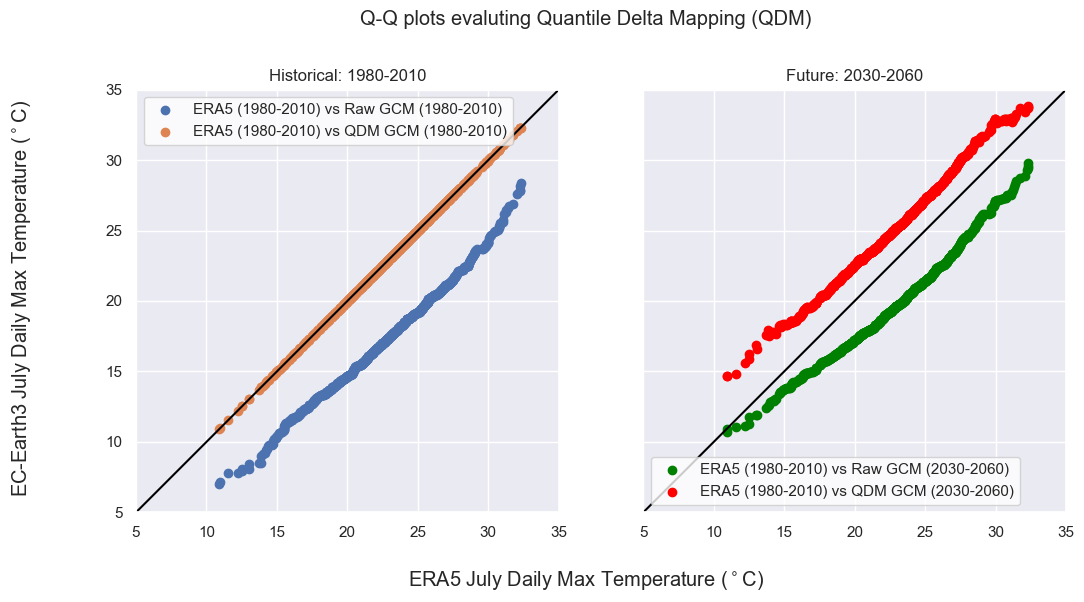

In [13]:
ref_invcdf = np.apply_along_axis(invcdf,axis=0,arr=ref_cdf,q0=hst_quantiles,
                                 q1=prj_quantiles)
hst_invcdf = np.apply_along_axis(invcdf,axis=0,arr=hst_cdf,q0=hst_quantiles,
                                 q1=prj_quantiles)

x_hst = np.sort(hst_pt['tasmax'].sel(time=prj_pt.time.dt.month==7).values)
x_prj = np.sort(prj_pt['tasmax'].sel(time=prj_pt.time.dt.month==7).values)

# This is the actual bias correction right here, adjusting the inverse cdf 
# (i.e. quantile function). Note that this would be multiplication '*' not 
# addition '+' for proportional deltas such as for precipitation, and the delta
# would be calculated using a ratio ('\' i.e. division), not subtraction.
hst_bias_corrected = ref_invcdf + (x_hst - hst_invcdf)
prj_bias_corrected = ref_invcdf + (x_prj - hst_invcdf)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6),sharex=True,sharey=True)

ax1.set_box_aspect(1)
ax1.scatter(ref_invcdf,x_hst,label='ERA5 (1980-2010) vs Raw GCM (1980-2010)')
ax1.scatter(ref_invcdf,hst_bias_corrected,label='ERA5 (1980-2010) vs QDM GCM (1980-2010)')
ax1.plot([5,35],[5,35],color='black')
ax1.set_xlim(5,35)
ax1.set_ylim(5,35)
ax1.legend(facecolor='white')
ax1.set_title('Historical: 1980-2010')
# ax1.show()

ax2.set_box_aspect(1)
ax2.scatter(ref_invcdf,x_prj,color='green',label='ERA5 (1980-2010) vs Raw GCM (2030-2060)')
ax2.scatter(ref_invcdf,prj_bias_corrected,color='red',label='ERA5 (1980-2010) vs QDM GCM (2030-2060)')
ax2.plot([5,35],[5,35],color='black')
ax2.legend(facecolor='white')
ax2.set_title('Future: 2030-2060')

fig.suptitle('Q-Q plots evaluting Quantile Delta Mapping (QDM)')
fig.supxlabel('ERA5 July Daily Max Temperature ($^\circ$C)')
fig.supylabel('EC-Earth3 July Daily Max Temperature ($^\circ$C)')

plt.show()

Above we can see the bias-corrected ouput for the Fairbanks grid cell comared to the "Raw" or uncorrected output for both the historical and future periods.  

Finally, compare the above manually derived results that would be calculated from the xclim library.  

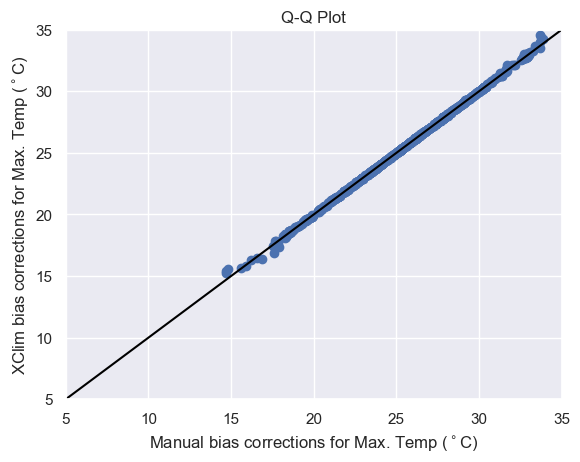

The mean absolute error between my calcs and XClim is 0.033 degrees


In [14]:
# Train qunatile delta mapping function
QDM = QuantileDeltaMapping.train(ref_pt['tasmax'],hst_pt['tasmax'],
                                 group='time.month',nquantiles=100,kind='+')

# Adjust projected GCM data using the QDM function just derived from training data
prj_QDM = QDM.adjust(prj_pt['tasmax']) 

plt.scatter(prj_bias_corrected,np.sort(prj_QDM.sel(time=prj_QDM.time.dt.month==7).values))
plt.plot([5,35],[5,35],color='black') # 1:1 line
plt.xlim(5,35)
plt.ylim(5,35)
plt.title('Q-Q Plot')
plt.xlabel('Manual bias corrections for Max. Temp ($^\circ$C)')
plt.ylabel('XClim bias corrections for Max. Temp ($^\circ$C)')
plt.show()

# Mean absolute error between my manual calculations and XClim
MAE = np.mean(np.abs(prj_bias_corrected 
              - np.sort(prj_QDM.sel(time=prj_QDM.time.dt.month==7).values)))
print('The mean absolute error between my calcs and XClim is %0.3f degrees' % MAE)


We can see that with a little bit of extra effort we can perform these bias corrections step-by-step to better understand the underlying method and theory published by [Cannon et al. 2015][7].

[7]: <https://doi.org/10.1175/JCLI-D-14-00754.1>

#### References
- xarray:               <https://docs.xarray.dev>  
- Cannon et al. 2015:   <https://doi.org/10.1175/JCLI-D-14-00754.1>  
- xclim:                <https://github.com/Ouranosinc/xclim>  
- ERA5:                 <https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5>  
- EC-Earth3-Veg:        <https://doi.org/10.5194/gmd-15-2973-2022>
- GCM-eval tool:        <https://gcmeval.met.no>